<a href="https://colab.research.google.com/github/byongkyu/Detecting-Concrete-Lining-in-Tunnel-GPR-Images/blob/main/Mask_R_CNN_ResNeXt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -m pip install roboflow
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-y241038s
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-y241038s
  Resolved https://github.com/facebookresearch/detectron2.git to commit 536dc9d527074e3b15df5f6677ffe1f4e104a4ab
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.8 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp311

In [ ]:
import logging
import torch
from collections import OrderedDict
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
import detectron2.utils.comm as comm
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)

from roboflow import Roboflow

from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
#register_coco_instances("my_dataset_train", {}, "/content/GPR_LINE-14/train/_annotations.coco.json", "/content/GPR_LINE-14/train")
#register_coco_instances("my_dataset_val", {}, "/content/GPR_LINE-14/valid/_annotations.coco.json", "/content/GPR_LINE-14/valid")
register_coco_instances("my_dataset_test", {}, "/content/drive/MyDrive/Mask R-CNN_ResNeXt_GPR/GPR_Concrete lining_Data/GPR_LINE-14/test/_annotations.coco.json", "/content/drive/MyDrive/Mask R-CNN_ResNeXt_GPR/GPR_Concrete lining_Data/GPR_LINE-14/test")

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
#cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 10000
cfg.SOLVER.STEPS = [7000, 9000]
cfg.SOLVER.CHECKPOINT_PERIOD = 300
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 27
cfg.TEST.EVAL_PERIOD = 0

PATIENCE = 1000
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
'''
def get_evaluator(cfg, dataset_name, output_folder=None):

    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    if evaluator_type in ["sem_seg", "coco_panoptic_seg"]:
        evaluator_list.append(
            SemSegEvaluator(
                dataset_name,
                distributed=True,
                output_dir=output_folder,
            )
        )
    if evaluator_type in ["coco", "coco_panoptic_seg"]:
        evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
    if evaluator_type == "coco_panoptic_seg":
        evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
    if evaluator_type == "cityscapes_instance":
        return CityscapesInstanceEvaluator(dataset_name)
    if evaluator_type == "cityscapes_sem_seg":
        return CityscapesSemSegEvaluator(dataset_name)
    if evaluator_type == "pascal_voc":
        return PascalVOCDetectionEvaluator(dataset_name)
    if evaluator_type == "lvis":
        return LVISEvaluator(dataset_name, cfg, True, output_folder)
    if len(evaluator_list) == 0:
        raise NotImplementedError(
            "no Evaluator for the dataset {} with the type {}".format(dataset_name, evaluator_type)
        )
    if len(evaluator_list) == 1:
        return evaluator_list[0]
    return DatasetEvaluators(evaluator_list)

def do_test(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        evaluator = get_evaluator(
            cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
        )
        results_i = inference_on_dataset(model, data_loader, evaluator)
        results[dataset_name] = results_i
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(dataset_name))
            print_csv_format(results_i)
    if len(results) == 1:
        results = list(results.values())[0]
    return results


logger = logging.getLogger("detectron2")
resume=False
model = build_model(cfg)
optimizer = build_optimizer(cfg, model)
scheduler = build_lr_scheduler(cfg, optimizer)

BEST_LOSS = np.inf

checkpointer = DetectionCheckpointer(
    model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
)
start_iter = (
    checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
)
prev_iter = start_iter
max_iter = cfg.SOLVER.MAX_ITER

periodic_checkpointer = PeriodicCheckpointer(
    checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
)

writers = default_writers(cfg.OUTPUT_DIR, max_iter) if comm.is_main_process() else []

data_loader = build_detection_train_loader(cfg)
logger.info("Starting training from iteration {}".format(start_iter))
patience_counter = 0
with EventStorage(start_iter) as storage:
    for data, iteration in zip(data_loader, range(start_iter, max_iter)):
        storage.iter = iteration

        loss_dict = model(data)
        losses = sum(loss_dict.values())
        assert torch.isfinite(losses).all(), loss_dict

        loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        if comm.is_main_process():
            storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
        scheduler.step()

        if (
            cfg.TEST.EVAL_PERIOD > 0
            and (iteration + 1) % cfg.TEST.EVAL_PERIOD == 0
            and iteration != max_iter - 1
        ):
            do_test(cfg, model)
            comm.synchronize()

        if iteration - start_iter > 5 and (
            (iteration + 1) % 20 == 0 or iteration == max_iter - 1
        ):
            for writer in writers:
                writer.write()
        periodic_checkpointer.step(iteration)

        if iteration > prev_iter:
            prev_iter = iteration
            if losses_reduced < BEST_LOSS:
                BEST_LOSS = losses_reduced
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter % 100 == 0:
                    print(f"Loss has not improved for {patience_counter} iterations")
                if patience_counter >= PATIENCE:
                    print(f"EARLY STOPPING")
                    break

do_test(cfg, model)
'''

In [ ]:
'''
%load_ext tensorboard
%tensorboard --logdir output
'''

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/drive/MyDrive/Mask R-CNN_ResNeXt_GPR/Model_Final/model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[05/03 09:03:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Mask R-CNN_ResNeXt_GPR/Model_Final/model_final.pth ...


In [ ]:
import cv2
import random
from google.colab.patches import cv2_imshow

In [ ]:
import os
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Ensure the output directory exists
output_directory = '/content/drive/MyDrive/Mask R-CNN_ResNeXt_GPR/'
os.makedirs(output_directory, exist_ok=True)

# Load test dataset
test_dataset_dicts = DatasetCatalog.get("my_dataset_test")
test_metadata = MetadataCatalog.get("my_dataset_test")

# Predict and save the results
for i, d in enumerate(test_dataset_dicts):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=test_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # removes the colors of unsegmented pixels
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    result_img = out.get_image()[:, :, ::-1]

    # Save the output image
    cv2.imwrite(os.path.join(output_directory, f"result_{i}.jpg"), result_img)

    if i % 10 == 0:
        print(f"Processed {i+1} images")


WARNING [05/03 09:05:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/03 09:05:29 d2.data.datasets.coco]: Loaded 100 images in COCO format from /content/drive/MyDrive/Mask R-CNN_ResNeXt_GPR/GPR_Concrete lining_Data/GPR_LINE-14/test/_annotations.coco.json


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)


Processed 1 images
Processed 11 images
Processed 21 images
Processed 31 images
Processed 41 images
Processed 51 images
Processed 61 images
Processed 71 images
Processed 81 images
Processed 91 images


In [ ]:
import cv2
import numpy as np
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# 이 함수는 각 테스트 이미지에 대해 예측을 수행하고, 모든 예측된 객체의 마스크를 하나의 색상으로 통합합니다.
def visualize_and_color_masks(predictor, dataset_dicts, output_directory):
    for i, d in enumerate(dataset_dicts):
        img = cv2.imread(d["file_name"])
        outputs = predictor(img)
        pred_masks = outputs["instances"].pred_masks.to("cpu").numpy()

        # 모든 마스크를 하나의 색상으로 통합하기 위해 결과 이미지를 초기화합니다.
        result_img = np.zeros_like(img)

        # 각 마스크를 빨간색으로 칠합니다.
        for mask in pred_masks:
            result_img[mask] = [0, 0, 255]  # BGR 색상 코드 (빨간색)

        # 결과 이미지를 저장합니다.
        cv2.imwrite(os.path.join(output_directory, f"colored_mask_{i}.jpg"), result_img)

        if i % 10 == 0:
            print(f"Processed {i+1} images")

# 테스트 데이터셋과 결과 저장 디렉터리 설정
test_dataset_dicts = DatasetCatalog.get("my_dataset_test")
output_directory = '/content/drive/MyDrive/Mask R-CNN_ResNeXt_GPR/Result_Red Mask'
os.makedirs(output_directory, exist_ok=True)

# Predictor 설정
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/drive/MyDrive/Mask R-CNN_ResNeXt_GPR/Model_Final/model_final.pth")  # 훈련된 모델 경로
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # 객체 감지 임계값
predictor = DefaultPredictor(cfg)

# 함수 호출로 이미지 처리 및 시각화
visualize_and_color_masks(predictor, test_dataset_dicts, output_directory)

WARNING [05/03 09:09:12 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/03 09:09:12 d2.data.datasets.coco]: Loaded 100 images in COCO format from /content/drive/MyDrive/Mask R-CNN_ResNeXt_GPR/GPR_Concrete lining_Data/GPR_LINE-14/test/_annotations.coco.json
[05/03 09:09:14 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Mask R-CNN_ResNeXt_GPR/Model_Final/model_final.pth ...
Processed 1 images
Processed 11 images
Processed 21 images
Processed 31 images
Processed 41 images
Processed 51 images
Processed 61 images
Processed 71 images
Processed 81 images
Processed 91 images


In [ ]:
dataset_dicts = DatasetCatalog.get("my_dataset_test")

WARNING [05/03 09:10:12 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/03 09:10:12 d2.data.datasets.coco]: Loaded 100 images in COCO format from /content/drive/MyDrive/Mask R-CNN_ResNeXt_GPR/GPR_Concrete lining_Data/GPR_LINE-14/test/_annotations.coco.json


In [ ]:
# 모델 경로 설정
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/Mask R-CNN_ResNeXt_GPR/Model_Final/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
predictor = DefaultPredictor(cfg)

[05/03 09:10:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Mask R-CNN_ResNeXt_GPR/Model_Final/model_final.pth ...


WARNING [05/03 09:11:44 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/03 09:11:44 d2.data.datasets.coco]: Loaded 100 images in COCO format from /content/drive/MyDrive/Mask R-CNN_ResNeXt_GPR/GPR_Concrete lining_Data/GPR_LINE-14/test/_annotations.coco.json


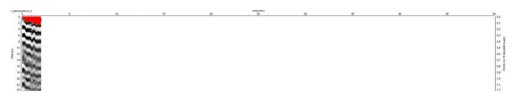

In [ ]:
from detectron2.utils.visualizer import Visualizer
import numpy as np

# 테스트 데이터셋에서 이미지 가져오기
dataset_dicts = DatasetCatalog.get("my_dataset_test")  # 테스트 데이터셋 사용
image_index = 2  # 테스트할 이미지 인덱스 지정
image_dict = dataset_dicts[image_index]  # 해당 인덱스의 이미지 딕셔너리 가져오기
image = cv2.imread(image_dict['file_name'])  # 이미지 파일 읽기

# 객체 탐지 수행
outputs = predictor(image)

# 붉은색 (빨간색) 설정
red_color = (0, 0, 255)  # OpenCV에서 색상은 (B, G, R) 순서

# 모든 객체의 마스크를 붉은색으로 변경하여 이미지에 적용
for mask in outputs["instances"].pred_masks:
    mask = mask.mul(255).byte().cpu().numpy()  # 마스크 값을 넘파이 배열로 변환
    red_mask = np.stack([mask, np.zeros_like(mask), np.zeros_like(mask)], axis=2)  # 붉은색으로 변경
    image[mask > 0] = red_color  # 이미지에 붉은색 마스크를 적용

# 이미지 저장
output_image_path = "/content/drive/MyDrive/Mask R-CNN_ResNeXt_GPR/Result_Red Mask_with_GPR.jpg"  # 이미지를 저장할 경로 및 파일 이름 지정
cv2.imwrite(output_image_path, image)


# 저장된 이미지 출력
output_image = cv2.imread(output_image_path)
output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)  # OpenCV의 BGR 형식을 RGB 형식으로 변환
plt.imshow(output_image)
plt.axis('off')
plt.show()

In [ ]:
from detectron2.utils.visualizer import Visualizer
import numpy as np
import os

# 저장할 디렉토리 생성
save_directory = "/content/drive/MyDrive/Mask R-CNN_ResNeXt_GPR/Result_Red Mask_with_GPR"
os.makedirs(save_directory, exist_ok=True)

# 테스트 데이터셋에서 이미지 가져오기
dataset_dicts = DatasetCatalog.get("my_dataset_test")  # 테스트 데이터셋 사용

# 객체 탐지 및 붉은색 마스크 적용 후 이미지 저장
for image_dict in dataset_dicts:
    image = cv2.imread(image_dict['file_name'])  # 이미지 파일 읽기
    original_filename = os.path.basename(image_dict['file_name'])  # 원본 파일 이름 가져오기

    # 객체 탐지 수행
    outputs = predictor(image)

    # 붉은색 (빨간색) 설정
    red_color = (0, 0, 255)  # OpenCV에서 색상은 (B, G, R) 순서

    # 모든 객체의 마스크를 붉은색으로 변경하여 이미지에 적용
    for mask in outputs["instances"].pred_masks:
        mask = mask.mul(255).byte().cpu().numpy()  # 마스크 값을 넘파이 배열로 변환
        red_mask = np.stack([mask, np.zeros_like(mask), np.zeros_like(mask)], axis=2)  # 붉은색으로 변경
        image[mask > 0] = red_color  # 이미지에 붉은색 마스크를 적용

    # 이미지 저장 (원본 파일 이름으로 저장)
    output_image_path = os.path.join(save_directory, original_filename)  # 이미지를 저장할 경로 및 파일 이름 지정
    cv2.imwrite(output_image_path, image)


WARNING [05/03 09:13:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/03 09:13:31 d2.data.datasets.coco]: Loaded 100 images in COCO format from /content/drive/MyDrive/Mask R-CNN_ResNeXt_GPR/GPR_Concrete lining_Data/GPR_LINE-14/test/_annotations.coco.json


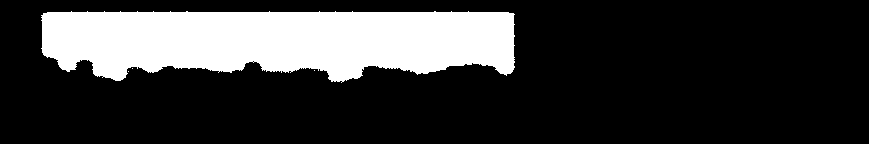

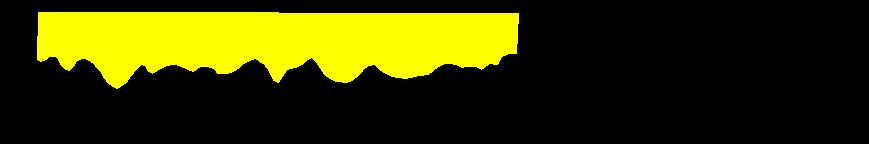

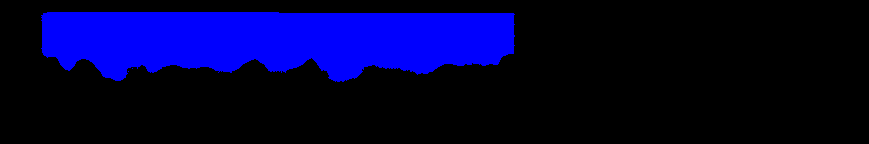

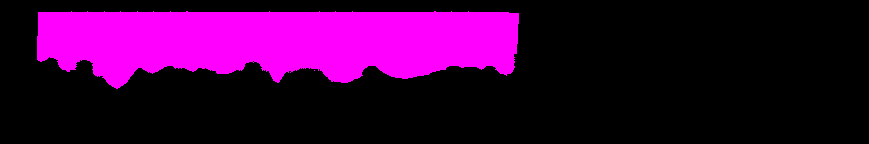

Selected Image: F_LC_S0981-1-0983-10_png.rf.75b98c79efc8093afddeeaa82b398167.jpg
IoU: 0.9562191838304718


In [ ]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

# 좌표 파일(txt에서 라벨링된 다각형 좌표 읽어오기
def read_coordinates_from_txt(file_path, original_width, original_height):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        coordinates = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) > 1:
                normalized_coords = [float(coord) for coord in parts[1:]]
                polygon = [(int(normalized_coords[i] * original_width), int(normalized_coords[i + 1] * original_height))
                           for i in range(0, len(normalized_coords), 2)]
                coordinates.append(polygon)
    return coordinates

# IOU 계산 함수
def calculate_iou(detected_polygons, labeled_polygon):
    intersection = cv2.bitwise_and(detected_polygons, labeled_polygon)
    intersection_area = np.count_nonzero(intersection)
    detected_area = np.count_nonzero(detected_polygons)
    label_area = np.count_nonzero(labeled_polygon)

    iou = intersection_area / (detected_area + label_area - intersection_area) if (detected_area + label_area - intersection_area) > 0 else 0
    return iou

def calculate_ious(detected_polygons, unioned_polygons):
    intersection = cv2.bitwise_and(detected_polygons, unioned_polygons)
    intersection_area = np.count_nonzero(intersection)
    unioned_area = np.count_nonzero(unioned_polygons)

    iou = intersection_area / unioned_area if unioned_area > 0 else 0
    return iou

# 경로 설정
original_images_path = "/content/drive/MyDrive/GPR_LINE_For_IoU/test/images"
label_images_path = "/content/drive/MyDrive/GPR_LINE_For_IoU/test/labels"
detected_images_path = "/content/drive/MyDrive/Mask R-CNN_ResNeXt_GPR/Result_Red Mask_with_GPR"

# 선택된 이미지 정보 설정
selected_image_idx = 13

# 선택된 이미지 파일명 가져오기
detected_images = sorted(os.listdir(detected_images_path))
selected_image = os.path.join(detected_images_path, detected_images[selected_image_idx])

# 탐지된 이미지 읽기
detected_image = cv2.imread(selected_image)

# 해당 이미지에 대한 라벨링된 이미지 및 원본 이미지 파일 경로 설정
selected_label_image_path = os.path.join(label_images_path, detected_images[selected_image_idx].replace(".jpg", ".txt"))
selected_original_image_path = os.path.join(original_images_path, detected_images[selected_image_idx])

# 라벨링된 이미지 읽기
label_image = cv2.imread(selected_original_image_path)
label_height, label_width = label_image.shape[:2]

# 라벨링된 다각형 좌표 읽어오기
label_coordinates = read_coordinates_from_txt(selected_label_image_path, label_width, label_height)

# 원본 이미지와 같은 크기의 빈 이미지 생성
labeled_image = np.zeros_like(detected_image)

# 라벨링된 이미지에 라벨링 추가 (색상 지정)
colors = [(0, 255, 255), (0, 0, 255), (255, 0, 0), (0, 255, 0)]  # 노란색, 빨간색, 파란색, 초록색 (BGR)
color_index = 0
for coordinates in label_coordinates:
    pts = np.array(coordinates, np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(labeled_image, [pts], color=colors[color_index])
    color_index = (color_index + 1) % len(colors)  # 색상 반복

# 탐지된 이미지 중 넓은 범위의 붉은색 색상 추출 (흰색으로 변경)
min_red = np.array([0, 0, 130])
max_red = np.array([110, 110, 255])
detected_red = cv2.inRange(detected_image, min_red, max_red)
detected_red_resized = cv2.resize(detected_red, (label_width, label_height))
detected_red_resized_3ch = cv2.merge([detected_red_resized, detected_red_resized, detected_red_resized])
detected_red_resized_3ch[np.any(detected_red_resized_3ch > 0, axis=2)] = [255, 255, 255]  # 흰색으로 변경

# 교집합 이미지 (색상 변경 없음)
intersection_image = cv2.bitwise_and(detected_red_resized_3ch, labeled_image)
intersection_image[np.any(intersection_image > 0, axis=2)] = [255, 0, 0]  # 파란색 (BGR)

# 합집합 이미지 (보라색으로 변경)
union_image = cv2.bitwise_or(detected_red_resized_3ch, labeled_image)
union_image[np.any(union_image > 0, axis=2)] = [255, 0, 255]

# IOU 계산
iou = calculate_ious(detected_red_resized_3ch, union_image)

# 시각화 (탐지된 붉은색 부분, 라벨링된 이미지, 교집합된 이미지, 합집합 이미지)
cv2_imshow(detected_red_resized_3ch)
cv2_imshow(labeled_image)
cv2_imshow(intersection_image)
cv2_imshow(union_image)

# 출력: 이미지 파일명과 해당 이미지의 IOU
print(f"Selected Image: {detected_images[selected_image_idx]}")
print(f"IoU: {iou}")

In [ ]:
import cv2
import numpy as np
import os

# 좌표 파일(txt)에서 라벨링된 다각형 좌표 읽어오기
def read_coordinates_from_txt(file_path, original_width, original_height):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        coordinates = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) > 1:
                normalized_coords = [float(coord) for coord in parts[1:]]
                polygon = [(int(normalized_coords[i] * original_width), int(normalized_coords[i + 1] * original_height))
                           for i in range(0, len(normalized_coords), 2)]
                coordinates.append(polygon)
    return coordinates

# IOU 계산 함수
def calculate_iou(detected_polygons, labeled_polygon):
    intersection = cv2.bitwise_and(detected_polygons, labeled_polygon)
    intersection_area = np.count_nonzero(intersection)
    label_area = np.count_nonzero(labeled_polygon)

    iou = intersection_area / label_area if label_area > 0 else 0
    return iou

def calculate_ious(detected_polygons, unioned_polygons):
    intersection = cv2.bitwise_and(detected_polygons, unioned_polygons)
    intersection_area = np.count_nonzero(intersection)
    unioned_area = np.count_nonzero(unioned_polygons)

    iou = intersection_area / unioned_area if unioned_area > 0 else 0
    return iou


# 경로 설정
original_images_path = "/content/drive/MyDrive/GPR_LINE_For_IoU/test/images"
label_images_path = "/content/drive/MyDrive/GPR_LINE_For_IoU/test/labels"
detected_images_path = "/content/drive/MyDrive/Mask R-CNN_ResNeXt_GPR/Result_Red Mask_with_GPR"

# 각 이미지의 IOU 계산 및 출력
total_iou = 0.0
num_images = len(detected_images)
for idx, detected_image_file in enumerate(detected_images):
    detected_image_path = os.path.join(detected_images_path, detected_image_file)
    detected_image = cv2.imread(detected_image_path)

    label_image_path = os.path.join(label_images_path, detected_image_file.replace(".jpg", ".txt"))
    original_image_path = os.path.join(original_images_path, detected_image_file)

    label_image = cv2.imread(original_image_path)
    label_height, label_width = label_image.shape[:2]

    label_coordinates = read_coordinates_from_txt(label_image_path, label_width, label_height)
    labeled_image = np.zeros_like(detected_image)

    for coordinates in label_coordinates:
        pts = np.array(coordinates, np.int32)
        pts = pts.reshape((-1, 1, 2))
        cv2.fillPoly(labeled_image, [pts], color=(0, 255, 0))

    # 색상 추출
    # 붉은색 색상 추출
    lower_red = np.array([0, 0, 150])  # 붉은색 범위의 최소 BGR 값
    upper_red = np.array([50, 50, 255])  # 붉은색 범위의 최대 BGR 값
    detected_red = cv2.inRange(detected_image, lower_red, upper_red)
    detected_red_resized = cv2.resize(detected_red, (label_width, label_height))
    detected_red_resized_3ch = cv2.merge([detected_red_resized, detected_red_resized, detected_red_resized])
    intersection_image = cv2.bitwise_and(detected_red_resized_3ch, labeled_image)

    # Calculate Union image
    union_image = cv2.bitwise_or(detected_red_resized_3ch, labeled_image)

    # IOU 계산
    iou = calculate_ious(detected_red_resized_3ch, union_image)
    total_iou += iou

    print(f"Image {idx + 1}/{num_images} - {detected_image_file}: IoU: {iou}")

# 전체 이미지의 평균 IOU 계산
average_iou = total_iou / num_images
print(f"Average IoU: {average_iou}")

Image 1/100 - 2_S0425-0-S0429-12-5_png.rf.0d437fc5d87dfcba764168f5674dba7a.jpg: IoU: 0.960422079219793
Image 2/100 - 2_S0625-0-0628-12-5_png.rf.a6e384a5a0657470f4416e714475d2f6.jpg: IoU: 0.9700394535086057
Image 3/100 - 5_0833-0-0835-4_F_png.rf.56619245e85b2b25c6fca4a7588b8de0.jpg: IoU: 0.9393228293664097
Image 4/100 - 5_S0950-8-0954-10_F_png.rf.d3637802cb1e5e911c4a4e7d6f459cb1.jpg: IoU: 0.9748076218395016
Image 5/100 - 6_S0368-0-0371-12-5_F_png.rf.7e9ca1f2bd33dc9918f4108c5ad9d933.jpg: IoU: 0.9559284691367091
Image 6/100 - 6_S0588-0-0591-12-5_F_png.rf.bcfe04b1704ffdf0407901b2f7fd31e2.jpg: IoU: 0.9938847981112541
Image 7/100 - 7_S0368-0-0369-7_png.rf.de3a5642cd1282ed3a4f77bbda911d0f.jpg: IoU: 0.9782620091914656
Image 8/100 - 7_S0833-0-0833-2_F_png.rf.269589c61d7bb92847cee024ebc94f24.jpg: IoU: 0.961764705882353
Image 9/100 - F_LC_S0880-5-0884-10_png.rf.ffabc51f661e55ede8bfbdb70fcc3d8a.jpg: IoU: 0.9934624985142042
Image 10/100 - F_LC_S0895-2-0899-10_png.rf.3ff97395e35ebf3fba592c7387273857